# Import stuff

In [107]:
from numpy import genfromtxt
import pandas as pd
import numpy as np
from scipy.stats import norm
from siren_pytorch import SirenNet
from siren_pytorch import Siren
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D# Import stuff
import copy
from mpl_toolkits import mplot3d
from matplotlib.pyplot import figure
import math

# Set parameters for the physical environment and the network model

In [298]:
#Physical Parameters
Q = 50*10**27 # (water) Outgassing rate: 1/s
rc = 2 # Comet size: km
uh = 0.800 # Neutral gas (water) outflow velocity: km/s
νio = 6*10**(-7) # Ionisation rate: 1/s
kns = 1.7*10**(-15) #Charge exchange rate: m^3/s
Th = 50 # Neutral gas temperature: K
msw = 1.66*10**(-27) # solar wind ion mass (1 amu): kg
mc = 17*msw # Average cometary ion mass: kg 
mh = mc
me = 9.12*10**(-31) # Electron mass: kg
e = 1.6*10**(-19) # Fundamental charge: C
Ccn = 10**(-15) # Cometary ion neutral elastic collision parameter
Cswn = 10**(-15) # Solar wind neutral elastic collision parameter
kB = 1.38*10**(-23) # Boltzmann: J/K
gamma = 5/3 #Adiabatic Index
mu0 = 1.26*10**(-6) # Vacuum permeability H/m

#Boundary Conditions for 1.3 AU
#Upstream Boundary
x_upstream = 10000 # Left bound of model: km
nsw_upstream = 6 # Solar wind proton density: 1/cm^3
usw_x_upstream = -4 # Solar wind velocity: 100*km/s
B_x_upstream = -2.97 # Magnetic field strength in sun direction: nT
B_y_upstream = -3.84 # Magnetic field strength in ecliptic plane: nT
Tsw_upstream = 10**5
psw_T_upstream = gamma*nsw_upstream*100**3*kB*2*Tsw_upstream
psw_B_upstream = ((B_x_upstream*10**(-9))**2 + (B_y_upstream*10**(-9))**2)/(2*mu0)
psw_upstream = (psw_T_upstream+psw_B_upstream)*10**11 #Undisturbed solar wind pressure: 10^-11 Pa
Tsw_upstream = 0.08 # Undisturbed solar wind temperature: M K
Te_upstream = 0.132 # Undistured solar wind electron temperature: M K

#Simulation parameters
d1 = 10000 # Large Simulation size: km
d2 = 30 # Small Simulation size: km
N1 = 32 # Number of spatial points per side in large domain
N2 = 48 # Number of spatial points per side in small domain

#Network Parameters
hidden_size = 50
num_epochs = 6400#2000
batch_size = N1+N2
learning_rate = 1e-2

nsw_scaling = 1
nc_scaling = 1000000 #how many ions per cm^3 the network wants

activation_smoothness_coarse = 800#50
activation_amplitude_coarse = 5

activation_smoothness_medium = 30#2
activation_amplitude_medium = 4

activation_smoothness_smooth = 6#2
activation_amplitude_smooth = 4

# Define all the functions

In [299]:
#DATA CREATION FUNCTIONS
def gen_xyz(size=N2,xmin=-d2,xmax=d2,ymin=-d2,ymax=d2,zmin=-d2,zmax=d2): #Generates N random points in the simulation domain
    x_output = torch.tensor(np.random.uniform(low = xmin, high = xmax, size = size), dtype=torch.float).view(-1,1)
    y_output = torch.tensor(np.random.uniform(low = ymin, high = ymax, size = size), dtype=torch.float).view(-1,1)
    z_output = torch.tensor(np.random.uniform(low = zmin, high = zmax, size = size), dtype=torch.float).view(-1,1)
    output = torch.cat((x_output,y_output,z_output),1).requires_grad_(True)
    output = output[output[:,0]**2+output[:,1]**2+output[:,2]**2 > rc**2]
    return output

def gen_xyz_double(N2=N2**2,xmin2=-d2,xmax2=d2,ymin2=-d2,ymax2=d2,zmin2=-d2,zmax2=d2,N1=N1**2,xmin1=-d1,xmax1=d1,ymin1=-d1,ymax1=d1,zmin1=-d1,zmax1=d1): #Generates two grids: high res and low res
    x_output = torch.tensor(np.append(np.random.uniform(low = xmin1, high = xmax1, size = N1),np.random.uniform(low = xmin2, high = xmax2, size = N2)), dtype=torch.float).view(-1,1)
    y_output = torch.tensor(np.append(np.random.uniform(low = ymin1, high = ymax1, size = N1),np.random.uniform(low = ymin2, high = ymax2, size = N2)), dtype=torch.float).view(-1,1)
    z_output = torch.tensor(np.append(np.random.uniform(low = zmin1, high = zmax1, size = N1),np.random.uniform(low = zmin2, high = zmax2, size = N2)), dtype=torch.float).view(-1,1)
    output = torch.cat((x_output,y_output,z_output),1).requires_grad_(True)
    output = output[output[:, 0]**2+output[:, 1]**2+output[:, 2]**2 > rc**2]
    return output

def gen_grid(size = 10,vsize = 3,xmin=-d2,xmax=d2,ymin=-d2,ymax=d2,zmin=-d2,zmax=d2): #Generates meshgrid for plotting. vsize is number of z slices. 
    x_output = torch.tensor(np.tile(np.linspace(xmin,xmax,size),size*vsize), dtype=torch.float).view(-1,1)
    y_output = torch.tensor(np.tile(np.repeat(np.linspace(ymin, ymax, size),size),vsize), dtype=torch.float).view(-1,1)
    if vsize == 1:
        z_output = torch.tensor(np.zeros(size**2), dtype=torch.float).view(-1,1)
    else:
        z_output = torch.tensor(np.repeat(np.linspace(zmin,zmax,vsize),size**2), dtype=torch.float).view(-1,1)
    output = torch.cat((x_output,y_output,z_output),1).requires_grad_(True)
    output = output[output[:,0]**2+output[:,1]**2+output[:,2]**2 > rc**2]
    return output

def gen_boundary(size = N1**2): #Generates N random points on upstream boundary
    x_output = d1*torch.ones((size,1), dtype=torch.float)
    y_output = torch.tensor(np.random.uniform(low = -d1, high = d1, size = size), dtype=torch.float).view(-1,1)
    z_output = torch.tensor(np.random.uniform(low = -d1, high = d1, size = size), dtype=torch.float).view(-1,1)
    output = torch.cat((x_output,y_output,z_output),1).requires_grad_(True)
    return output

def neutral_density(xyz_in): #Takes xyz_input tensor and returns neutral density tensor in num/cm^3
    x_in,y_in,z_in = split_xyz(xyz_in)
    x_in=x_in*1000
    y_in=y_in*1000
    z_in=z_in*1000
    nh_out = (1/((1/Q)*4*np.pi*uh*1000*(x_in**2+y_in**2+z_in**2))*torch.exp(-(νio/(uh*1000))*(x_in**2+y_in**2+z_in**2)**0.5))*(1/100)**3
    return nh_out

def neutral_velocity(xyz_in): #Takes xyz_input tensor (in km) and returns neutral velocity in km/s
    x_in,y_in,z_in = split_xyz(xyz_in)
    uh_out = []
    for i in [x_in,y_in,z_in]:
        uh_out.append(uh*i/(x_in**2+y_in**2+z_in**2)**0.5)
    return uh_out[0],uh_out[1],uh_out[2]


#TENSOR MANIPULATION FUNCTIONS
def split_xyz(xyz_in): #Separates xyz_input tensor into separate x,y,z tensors
    return xyz_in[:,0].reshape(-1,1),xyz_in[:,1].reshape(-1,1),xyz_in[:,2].reshape(-1,1)

def detach_xyz(xyz_in):
    return xyz_in[:,0].detach().numpy(),xyz_in[:,1].detach().numpy(),xyz_in[:,2].detach().numpy()

def grad(tensor,xyz_in): #Take a tensor, and compute its derivates with respect to x y z 
    grad = torch.autograd.grad(tensor, xyz_in, grad_outputs = torch.ones_like(tensor), create_graph = True)[0]/10**3
    return grad[:,0].reshape(-1, 1), grad[:,1].reshape(-1, 1), grad[:,2].reshape(-1, 1)


#PLOTTING FUNCTIONS
def density_quiver_plot(xyz_den, density_tensor, xyz_vec, vec1_tensor, vec2_tensor):
    x_den,y_den,z_den = detach_xyz(xyz_den)
    density = density_tensor.detach().numpy()
    x_vec,y_vec,z_vec = detach_xyz(xyz_vec)
    vec1 = vec1_tensor.detach().numpy()
    vec2 = vec2_tensor.detach().numpy()
    vec_avg = np.average(np.sqrt(vec1**2+vec2**2))
        
    figure(figsize=(4,4))
    plt.scatter(x_den,y_den,c=density)
    plt.colorbar(fraction=0.046, pad=0.04, label = "number / cm^3")
    plt.quiver(x_vec,y_vec,vec1,vec2,scale = 15,color = "white")
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.show()
           
    print("Average vector magnitude:",vec_avg,"km/s")

#NEURAL NETWORK FUNCTIONS
class ActivationCoarse(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, input):
        return torch.abs(activation_amplitude_coarse*torch.sin(input/activation_smoothness_coarse))
    
class ActivationMedium(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, input):
        return torch.abs(activation_amplitude_medium*torch.sin(input/activation_smoothness_medium))
    
class ActivationSmooth(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, input):
        return torch.abs(activation_amplitude_smooth*torch.sin(input/activation_smoothness_smooth))
    
def evaluate_models(xyz):
    sw_network_output = sw_model(xyz)
    comet_network_output = comet_model(xyz)
    e_network_output = e_model(xyz)
    B_network_output = B_model(xyz)
    output = [sw_network_output,comet_network_output,e_network_output,B_network_output]
    return output
    
def loss_function(xyz_in,model_in):
    #Network Architecture:
    #Inputs: 
    #0: x - distance, in km
    #0: y - distance, in km
    #0: z - distance, in km
    
    #Outputs:
    #0,0: nsw - ln solar wind ion density, in sw_scaling/cm^3
    #0,1: psw - ln solar wind ion pressure, in 10^-11 Pa
    #0,2: Tsw - solar wind ion temperature , in 10^6 K
    #0,3: usw_x - cometary ion x velocity, in 100*km/s
    #0,4: usw_y - cometary ion y velocity, in 100*km/s
    #0,5: usw_z - cometary ion z velocity, in 100*km/s
    
    #1,0: nc - ln cometary ion density, in nc_scaling/cm^3
    #1,1: pc - ln cometary ion pressure, in 10^-11 Pa
    #1,2: Tc - cometary ion temperature , in 10^6 K
    #1,3: uc_x - cometary ion x velocity, in 100*km/s
    #1,4: uc_y - cometary ion y velocity, in 100*km/s
    #1,5: uc_z - cometary ion z velocity, in 100*km/s
    
    #2,0: pe - Electron pressure: 10^-11 Pa)
    #2,1: Te - Electron temperature: 10^6 K)
    #2,2: ue_x - electron x velocity, in km/s
    #2,3: ue_y - electron y velocity, in km/s
    #2,4: ue_z - electron z velocity, in km/s
    
    #3,0: B_x (Magnetic field x-component: nT)
    #3,1: B_y (Magnetic field y-component: nT)
    #3,2: B_z (Magnetic field z-component: nT)
    
    
    #Extract Physical Parameters
    x,y,z = split_xyz(xyz_in)
    x = x*1000 # m
    y = y*1000 # m
    z = z*1000 # m
    
    nsw = torch.exp(model_in[0][:,0].reshape(-1,1))*nsw_scaling*(100)**3 # 1/m^3
    psw = torch.exp(model_in[0][:,1].reshape(-1,1))*10**(-11) # Pa
    Tsw = model_in[0][:,2].reshape(-1,1)*10**6 # K
    usw_x = model_in[0][:,3].reshape(-1,1)*1000*100 # m/s
    usw_y = model_in[0][:,4].reshape(-1,1)*1000*100 # m/s
    usw_z = model_in[0][:,5].reshape(-1,1)*1000*100 # m/s
    
    nc = torch.exp(model_in[1][:,0].reshape(-1,1))*nc_scaling*(100)**3 # 1/m^3
    pc = torch.exp(model_in[1][:,1].reshape(-1,1))*10**(-11) # Pa
    Tc = model_in[1][:,2].reshape(-1,1)*10**6 # K
    uc_x = model_in[1][:,3].reshape(-1,1)*1000*100 # m/s
    uc_y = model_in[1][:,4].reshape(-1,1)*1000*100 # m/s
    uc_z = model_in[1][:,5].reshape(-1,1)*1000*100 # m/s
    
    ne = nc+nsw
    pe = 0
    Te = 10**4                                
    ue_x = uc_x+usw_x#model_in[:,14].reshape(-1,1)*1000 # m/s
    ue_y = uc_y+usw_y#model_in[:,15].reshape(-1,1)*1000 # m/s
    ue_z = uc_z+usw_z#model_in[:,16].reshape(-1,1)*1000 # m/s
    
    B_x = model_in[3][:,0].reshape(-1,1)*10**(-9) # T
    B_y = model_in[3][:,1].reshape(-1,1)*10**(-9) # T
    B_z = model_in[3][:,2].reshape(-1,1)*10**(-9) # T
    
    
    #Compute non-modelled terms
    
    uplus_x = (nsw*usw_x + nc*uc_x)/ne # Charge averaged ion velcoity: m/s 
    uplus_y = (nsw*usw_y + nc*uc_y)/ne # m/s 
    uplus_z = (nsw*usw_z + nc*uc_z)/ne # m/s 
    
    E_x = uplus_z*B_y - uplus_y*B_z # V/m
    E_y = uplus_x*B_z - uplus_z*B_x # V/m
    E_z = uplus_y*B_x - uplus_x*B_y # V/m
    
    #Compute Derivatives
    dnsw_dx, dnsw_dy, dnsw_dz = grad(nsw,xyz_in)
    dpsw_dx, dpsw_dy, dpsw_dz = grad(psw,xyz_in)
    dusw_x_dx, dusw_x_dy, dusw_x_dz = grad(usw_x,xyz_in)
    dusw_y_dx, dusw_y_dy, dusw_y_dz = grad(usw_y,xyz_in)
    dusw_z_dx, dusw_z_dy, dusw_z_dz = grad(usw_z,xyz_in)
    
    dnc_dx, dnc_dy, dnc_dz = grad(nc,xyz_in)
    dpc_dx, dpc_dy, dpc_dz = grad(pc,xyz_in)
    duc_x_dx, duc_x_dy, duc_x_dz = grad(uc_x,xyz_in)
    duc_y_dx, duc_y_dy, duc_y_dz = grad(uc_y,xyz_in)
    duc_z_dx, duc_z_dy, duc_z_dz = grad(uc_z,xyz_in)
    
    dE_x_dx, dE_x_dy, dE_x_dz = grad(E_x,xyz_in)
    dE_y_dx, dE_y_dy, dE_y_dz = grad(E_y,xyz_in)
    dE_z_dx, dE_z_dy, dE_z_dz = grad(E_z,xyz_in)
    
    
    #Compute Intermediate Terms
    nh = neutral_density(xyz_in)*100**3 # 1/m^3
    uh_x,uh_y,uh_z = neutral_velocity(xyz_in)
    uh_x = uh_x*1000 # m/s
    uh_y = uh_y*1000 # m/s
    uh_z = uh_z*1000 # m/s
    
    mcsw = mc*msw/(mc+msw) # solar wind cometary ion reduced mass
    Tcsw = (mc*Tsw+msw*Tc)/(msw+mc) # solar wind cometary ion reduced temperature
    
    alpha_sw = 4.8*10**(-18)*(250/Te)**0.7
    alpha_c = 4.73*10**(-11)*(Te)**(-0.74)
    
    νswe = 54.5*10**(-6)*nsw/(Te**(3/2)) # solar wind ion-electron elastic collision coefficient
    νce = 54.5*10**(-6)*nc/(Te**(3/2)) 
    νswc = 0#1.27*10**(-6)*mcsw**(1/2)*nc/(msw*(Tcsw**(3/2))) # solar wind on cometary ion elastic collision coefficient
    νcsw = 0#1.27*10**(-6)*mcsw**(1/2)*nsw/(mc*(Tcsw**(3/2)))
    νswn = 10**(-6)*Cswn*nh # Solar wind neutral elastic collision coefficient
    νcn = 10**(-6)*Ccn*nh 
    
    #Continuity Equation
    #LHS
    #Solar wind
    continuity_LHS_sw = msw*((dnsw_dx*usw_x + nsw*dusw_x_dx) + (dnsw_dy*usw_y + nsw*dusw_y_dy) + (dnsw_dz*usw_z + nsw*dusw_z_dz))
    #Comet
    continuity_LHS_c = mc*((dnc_dx*uc_x + nc*duc_x_dx) + (dnc_dy*uc_y + nc*duc_y_dy) + (dnc_dz*uc_z + nc*duc_z_dz))
    #RHS
    #Solar wind
    continuity_RHS_sw = -msw*nh*nsw*kns - msw*alpha_sw*ne*nsw
    #Comet
    continuity_RHS_c = mc*νio*nh + mc*nh*nsw*kns - mc*alpha_c*ne*nc
    
    #Momentum Equation
    #LHS
    #Solar Wind
    momentum_LHS_sw_x = usw_x**2*msw*dnsw_dx + 2*usw_x*msw*nsw*dusw_x_dx + usw_y**2*msw*dnsw_dx + 2*usw_y*msw*nsw*dusw_y_dx + usw_z**2*msw*dnsw_dx + 2*usw_z*msw*nsw*dusw_z_dx + dpsw_dx - e*nsw*(E_x + (usw_y*B_z - usw_z*B_y))
    momentum_LHS_sw_y = usw_x**2*msw*dnsw_dy + 2*usw_x*msw*nsw*dusw_x_dy + usw_y**2*msw*dnsw_dy + 2*usw_y*msw*nsw*dusw_y_dy + usw_z**2*msw*dnsw_dy + 2*usw_z*msw*nsw*dusw_z_dy + dpsw_dy - e*nsw*(E_y + (usw_z*B_x - usw_x*B_z))
    momentum_LHS_sw_z = usw_x**2*msw*dnsw_dz + 2*usw_x*msw*nsw*dusw_x_dz + usw_y**2*msw*dnsw_dz + 2*usw_y*msw*nsw*dusw_y_dz + usw_z**2*msw*dnsw_dz + 2*usw_z*msw*nsw*dusw_z_dz + dpsw_dz - e*nsw*(E_z + (usw_x*B_y - usw_y*B_x))
    #Cometary Ions
    momentum_LHS_c_x = uc_x**2*mc*dnc_dx + 2*uc_x*mc*nc*duc_x_dx + uc_y**2*mc*dnc_dx + 2*uc_y*mc*nc*duc_y_dx + uc_z**2*mc*dnc_dx + 2*uc_z*mc*nc*duc_z_dx + dpc_dx - e*nc*(E_x + (uc_y*B_z - uc_z*B_y))
    momentum_LHS_c_y = uc_x**2*mc*dnc_dy + 2*uc_x*mc*nc*duc_x_dy + uc_y**2*mc*dnc_dy + 2*uc_y*mc*nc*duc_y_dy + uc_z**2*mc*dnc_dy + 2*uc_z*mc*nc*duc_z_dy + dpc_dy - e*nc*(E_y + (uc_z*B_x - uc_x*B_z))
    momentum_LHS_c_z = uc_x**2*mc*dnc_dz + 2*uc_x*mc*nc*duc_x_dz + uc_y**2*mc*dnc_dz + 2*uc_y*mc*nc*duc_y_dz + uc_z**2*mc*dnc_dz + 2*uc_z*mc*nc*duc_z_dz + dpc_dz - e*nc*(E_z + (uc_x*B_y - uc_y*B_x))
    #RHS
    #Solar Wind
    momentum_RHS_sw_x = - mc*nh*nsw*kns*(uh_x-usw_x) - msw*νswe*nsw*(usw_x-ue_x) + usw_x*continuity_RHS_sw #+ msw*nsw*νswc*(uc_x-usw_x) #+ msw*nsw*νswn*(uh_x-usw_x)
    momentum_RHS_sw_y = - mc*nh*nsw*kns*(uh_y-usw_y) - msw*νswe*nsw*(usw_y-ue_y) + usw_y*continuity_RHS_sw #+ msw*nsw*νswc*(uc_y-usw_y) #+ msw*nsw*νswn*(uh_y-usw_y)
    momentum_RHS_sw_z = - mc*nh*nsw*kns*(uh_z-usw_z) - msw*νswe*nsw*(usw_z-ue_z) + usw_z*continuity_RHS_sw #+ msw*nsw*νswc*(uc_z-usw_z) #+ msw*nsw*νswn*(uh_z-usw_z)
    #Cometary Ions
    momentum_RHS_c_x = mc*νio*nh*(uh_x-uc_x) + mc*nh*nsw*kns*(uh_x-uc_x) - mc*νce*nc*(uc_x-ue_x) + mc*nc*νcsw*(usw_x-uc_x) + uc_x*continuity_RHS_c #+ mc*nc*νcn*(uh_x-uc_x)
    momentum_RHS_c_y = mc*νio*nh*(uh_y-uc_y) + mc*nh*nsw*kns*(uh_y-uc_y) - mc*νce*nc*(uc_y-ue_y) + mc*nc*νcsw*(usw_y-uc_y) + uc_y*continuity_RHS_c #+ mc*nc*νcn*(uh_y-uc_y)
    momentum_RHS_c_z = mc*νio*nh*(uh_z-uc_z) + mc*nh*nsw*kns*(uh_z-uc_z) - mc*νce*nc*(uc_z-ue_z) + mc*nc*νcsw*(usw_z-uc_z) + uc_z*continuity_RHS_c #+ mc*nc*νcn*(uh_z-uc_z)
    
    #Pressure Equation
    #LHS
    #Solar Wind
    pressure_LHS_sw = (usw_x*dpsw_dx+usw_y*dpsw_dy+usw_z*dpsw_dz) + gamma*psw*(dusw_x_dx+dusw_y_dy+dusw_z_dz)
    #Cometary Ions
    pressure_LHS_c = (uc_x*dpc_dx+uc_y*dpc_dy+uc_z*dpc_dz) + gamma*pc*(duc_x_dx+duc_y_dy+duc_z_dz)
    #RHS
    #Solar Wind
    pressure_RHS_sw = -psw*nh*nsw*kns - psw*alpha_sw*ne + 2*νswc*(msw/(mc+msw))*nsw*kB*(Tc-Tsw) + (2/3)*νswc*mcsw*nsw*((uc_x-usw_x)**2+(uc_y-usw_y)**2+(uc_z-usw_z)**2) + 2*νswn*(msw/(mh+msw))*nsw*kB*(Th-Tsw) + (2/3)*νswn*(mh*msw/(mh+msw))*nsw*((uh_x-usw_x)**2+(uh_y-usw_y)**2+(uh_z-usw_z)**2) + 2*νswe*nsw*kB*(Te-Tsw) + (2/3)*νswe*me*nsw*((ue_x-usw_x)**2+(ue_y-usw_y)**2+(ue_z-usw_z)**2)
    #Cometary Ions
    pressure_RHS_c = -pc*alpha_c*ne + 2*νcsw*(mc/(mc+msw))*nc*kB*(Tsw-Tc) + (2/3)*νcsw*mcsw*nc*((uc_x-usw_x)**2+(uc_y-usw_y)**2+(uc_z-usw_z)**2) + 2*νcn*(mc/(mh+mc))*nc*kB*(Th-Tc) + (2/3)*νcn*(mh*mc/(mh+mc))*nc*((uh_x-uc_x)**2+(uh_y-uc_y)**2+(uh_z-uc_z)**2) + 2*νce*nc*kB*(Te-Tc) + (2/3)*νce*me*nc*((ue_x-uc_x)**2+(ue_y-uc_y)**2+(ue_z-uc_z)**2) + (1/3)*mc*νio*nh*((uh_x-uc_x)**2+(uh_y-uc_y)**2+(uh_z-uc_z)**2) + (1/3)*mc*nc*nsw*kns*((uh_x-uc_x)**2+(uh_y-uc_y)**2+(uh_z-uc_z)**2)
    
    #INDUCTION
    #LHS
    induction_LHS_x = (dE_z_dy-dE_y_dz)
    induction_LHS_y = (dE_x_dz-dE_z_dx)
    induction_LHS_z = (dE_y_dx-dE_x_dy)
    
    #Precompute loss terms
    tensor_list = []
    total_norm = 0
    total = 0
    term_list = [
                (continuity_LHS_sw - continuity_RHS_sw),
                (continuity_LHS_c - continuity_RHS_c),
                (momentum_LHS_sw_x - momentum_RHS_sw_x),
                (momentum_LHS_sw_y - momentum_RHS_sw_y),
                (momentum_LHS_sw_z - momentum_RHS_sw_z),
                (momentum_LHS_c_x - momentum_RHS_c_x),
                (momentum_LHS_c_y - momentum_RHS_c_y),
                (momentum_LHS_c_z - momentum_RHS_c_z),
                (pressure_LHS_sw - pressure_RHS_sw),
                (pressure_LHS_c - pressure_RHS_c),
                #(induction_LHS_x),
                #(induction_LHS_y),
                #(induction_LHS_z)
                ]

    for i in term_list:
        tensor_i = torch.abs(i)
        norm_i = tensor_i.sum().item()
        total_norm += norm_i
        tensor_list.append(tensor_i/np.sqrt(norm_i**2))
        total += tensor_i/np.sqrt(norm_i**2)
    
    #Collect loss result
    output = (np.sqrt(total_norm**2)*total).sum()
    return output, total_norm
    
    

# Initialise Networks and Train

Network update: epoch number 0 out of 6400
Cometary Ion density, close-up


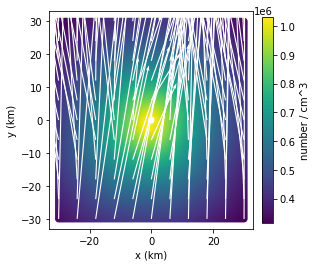

Average vector magnitude: 20.00913 km/s
Solar wind ion density


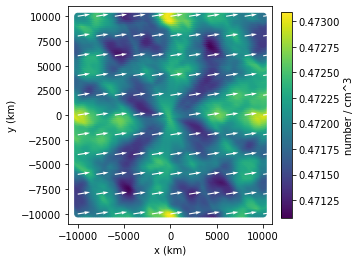

Average vector magnitude: 0.91567266 km/s
Magnetic field, close up


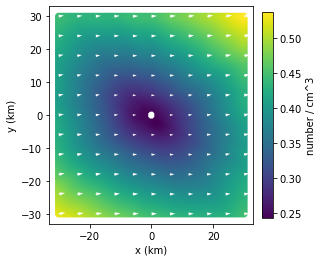

Average vector magnitude: 0.3735934 km/s
Magnetic field, whole simulation


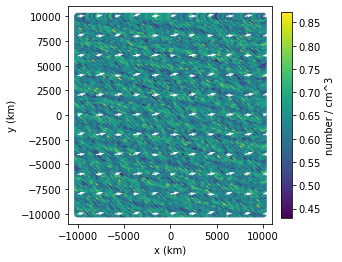

Average vector magnitude: 0.5712752 km/s
Network update: epoch number 1600 out of 6400
Cometary Ion density, close-up


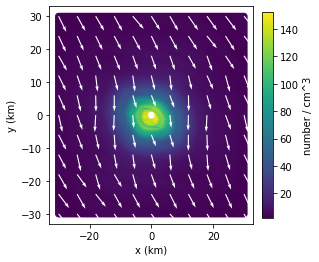

Average vector magnitude: 1.1766129 km/s
Solar wind ion density


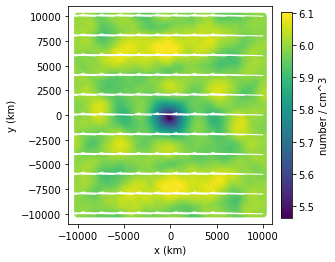

Average vector magnitude: 3.9897497 km/s
Magnetic field, close up


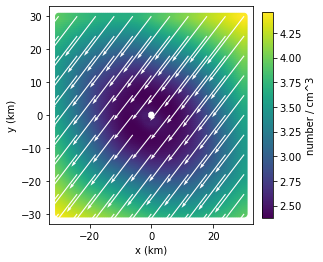

Average vector magnitude: 3.319748 km/s
Magnetic field, whole simulation


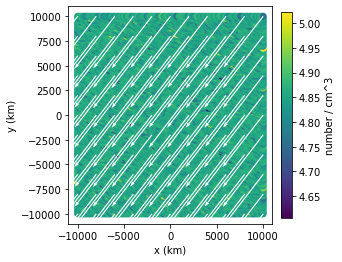

Average vector magnitude: 4.851008 km/s
Network update: epoch number 3200 out of 6400
Cometary Ion density, close-up


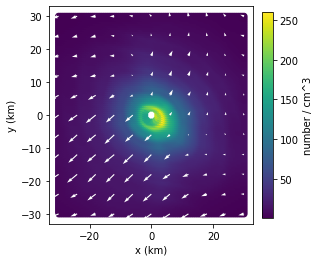

Average vector magnitude: 0.48294622 km/s
Solar wind ion density


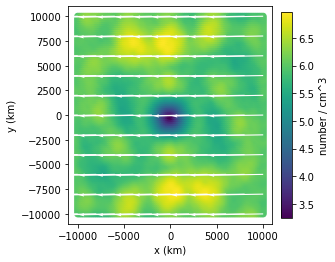

Average vector magnitude: 4.0054073 km/s
Magnetic field, close up


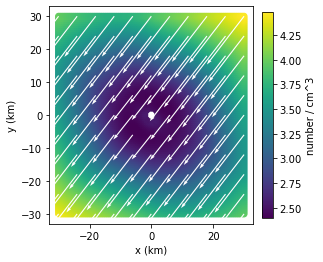

Average vector magnitude: 3.35523 km/s
Magnetic field, whole simulation


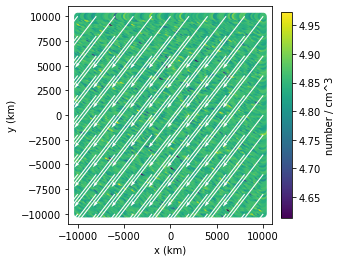

Average vector magnitude: 4.85224 km/s
Network update: epoch number 4800 out of 6400
Cometary Ion density, close-up


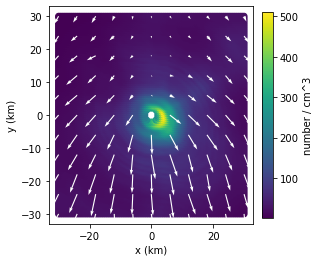

Average vector magnitude: 0.9877981 km/s
Solar wind ion density


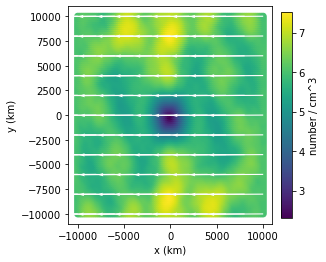

Average vector magnitude: 4.008339 km/s
Magnetic field, close up


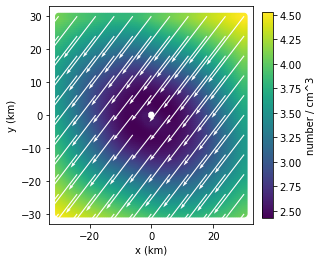

Average vector magnitude: 3.4221888 km/s
Magnetic field, whole simulation


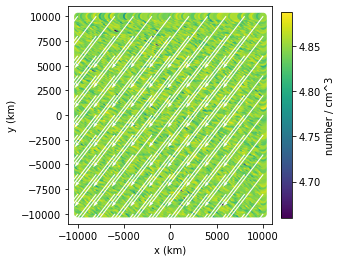

Average vector magnitude: 4.847898 km/s


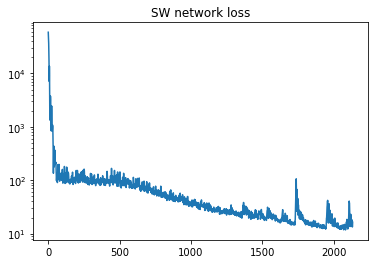

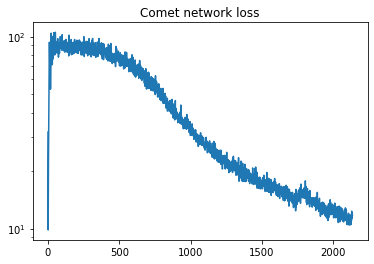

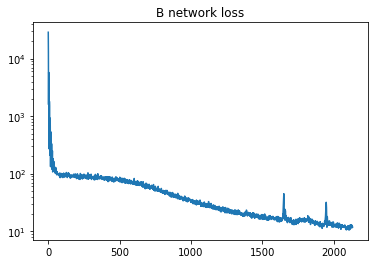

In [300]:
sw_NeuralNet = nn.Sequential(
    torch.nn.Linear(3, hidden_size),
    ActivationCoarse(),
    torch.nn.Linear(hidden_size, hidden_size),
    ActivationCoarse(),
    torch.nn.Linear(hidden_size, hidden_size),
    nn.Softplus(),
    torch.nn.Linear(hidden_size, 6),
    )

comet_NeuralNet = nn.Sequential(
    torch.nn.Linear(3, hidden_size),
    ActivationMedium(),
    torch.nn.Linear(hidden_size, hidden_size),
    ActivationSmooth(),
    torch.nn.Linear(hidden_size, hidden_size),
    nn.Softplus(),
    torch.nn.Linear(hidden_size, 6),
    )

e_NeuralNet = nn.Sequential(
    torch.nn.Linear(3, hidden_size),
    ActivationCoarse(),
    torch.nn.Linear(hidden_size, hidden_size),
    ActivationSmooth(),
    torch.nn.Linear(hidden_size, hidden_size),
    nn.Softplus(),
    torch.nn.Linear(hidden_size, 5),
    )

B_NeuralNet = nn.Sequential(
    torch.nn.Linear(3, hidden_size),
    ActivationMedium(),
    torch.nn.Linear(hidden_size, hidden_size),
    ActivationSmooth(),
    torch.nn.Linear(hidden_size, hidden_size),
    nn.Softplus(),
    torch.nn.Linear(hidden_size, 3),
    )

###### NN nonsense #####
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data loader
def DataLoad(X,Y):
    batch_size = len(xyz)
    train_dataset = torch.utils.data.TensorDataset(X,Y)
    train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=False)
    return train_dataset, train_loader

#Call networks
sw_model = sw_NeuralNet.to(device)
comet_model = comet_NeuralNet.to(device)
e_model = e_NeuralNet.to(device)
B_model = B_NeuralNet.to(device)

#Loss, optimizer and friends
sw_optimizer = torch.optim.Adam(sw_model.parameters(), lr=learning_rate)
comet_optimizer = torch.optim.Adam(comet_model.parameters(), lr=learning_rate)
B_optimizer = torch.optim.Adam(B_model.parameters(), lr=learning_rate)
sw_training_loss = []
comet_training_loss = []
B_training_loss =[]
############

#Train the network
for epoch in range(num_epochs):
        
    xyz = gen_xyz_double()
    xyz_bound = gen_boundary()
        
    train_dataset, train_loader = DataLoad(xyz,xyz)
        
    for i, (features, true_val) in enumerate(train_loader):
        
        features.requires_grad_(True)
        
        # Forward pass
        output = evaluate_models(features.float()) #returns a list with network outputs: sw, comet, e, B
        loss,loss_value = loss_function(features.float(),output)
        
        if epoch % 3==0:
            comet_optimizer.zero_grad()
            loss.backward() 
            comet_optimizer.step()
            comet_training_loss.append(loss.item())
        elif epoch % 3==1:
            bound = sw_model(xyz_bound)
            loss += ((nsw_scaling*torch.exp(bound[:,0]).reshape(-1,1) - nsw_upstream)**2 +
                    (torch.exp(bound[:,1]).reshape(-1,1) - psw_upstream)**2 +
                    (bound[:,2].reshape(-1,1) - Tsw_upstream)**2 +
                    (bound[:,3].reshape(-1,1) - usw_x_upstream)**2 +
                    (bound[:,4].reshape(-1,1))**2 +
                    (bound[:,5].reshape(-1,1))**2).sum()
            sw_optimizer.zero_grad()
            loss.backward() 
            sw_optimizer.step()
            sw_training_loss.append(loss.item())
        else:
            bound = B_model(xyz_bound)
            loss += ((bound[:,0].reshape(-1,1) - B_x_upstream)**2 +
                     (bound[:,1].reshape(-1,1) - B_y_upstream)**2 +
                     (bound[:,2].reshape(-1,1))**2
                    ).sum()
            B_optimizer.zero_grad()
            loss.backward() 
            B_optimizer.step()
            B_training_loss.append(loss.item())
            
        
        if epoch % (num_epochs/4) == 0 and i ==0:
            print("Network update: epoch number",epoch,"out of",num_epochs)
            print("Cometary Ion density, close-up")
            xyz_den = gen_grid(100,1)
            xyz_vec = gen_grid(11,1)
            nc = nc_scaling*torch.exp(comet_model(xyz_den)[:,0].reshape(-1,1))
            uc_x = comet_model(xyz_vec)[:,3].reshape(-1,1)*100
            uc_y = comet_model(xyz_vec)[:,4].reshape(-1,1)*100
            density_quiver_plot(xyz_den, nc, xyz_vec, uc_x, uc_y)
            
            print("Solar wind ion density")
            xyz_den = gen_grid(100,1,-d1,d1,-d1,d1,-d1,d1)
            xyz_vec = gen_grid(11,1,-d1,d1,-d1,d1,-d1,d1)
            nsw = nsw_scaling*torch.exp(sw_model(xyz_den)[:,0].reshape(-1,1))
            usw_x = sw_model(xyz_vec)[:,3].reshape(-1,1)
            usw_y = sw_model(xyz_vec)[:,4].reshape(-1,1)
            density_quiver_plot(xyz_den, nsw, xyz_vec, usw_x, usw_y)
            
            print("Magnetic field, close up")
            xyz_den = gen_grid(100,1)
            xyz_vec = gen_grid(11,1)
            B_x = B_model(xyz_vec)[:,0].reshape(-1,1)
            B_y = B_model(xyz_vec)[:,1].reshape(-1,1)
            B_z = B_model(xyz_vec)[:,2].reshape(-1,1)
            B_mag = (B_model(xyz_den)[:,0].reshape(-1,1)**2+B_model(xyz_den)[:,1].reshape(-1,1)**2+B_model(xyz_den)[:,2].reshape(-1,1)**2)**0.5
            density_quiver_plot(xyz_den, B_mag, xyz_vec, B_x, B_y)
            
            print("Magnetic field, whole simulation")
            xyz_den = gen_grid(100,1,-d1,d1,-d1,d1,-d1,d1)
            xyz_vec = gen_grid(11,1,-d1,d1,-d1,d1,-d1,d1)
            B_x = B_model(xyz_vec)[:,0].reshape(-1,1)
            B_y = B_model(xyz_vec)[:,1].reshape(-1,1)
            B_z = B_model(xyz_vec)[:,2].reshape(-1,1)
            B_mag = (B_model(xyz_den)[:,0].reshape(-1,1)**2+B_model(xyz_den)[:,1].reshape(-1,1)**2+B_model(xyz_den)[:,2].reshape(-1,1)**2)**0.5
            density_quiver_plot(xyz_den, B_mag, xyz_vec, B_x, B_y)
        
plt.plot(sw_training_loss)
plt.yscale("log")
plt.title("SW network loss")
plt.show()
plt.plot(comet_training_loss)
plt.yscale("log")
plt.title("Comet network loss")
plt.show()
plt.plot(B_training_loss)
plt.yscale("log")
plt.title("B network loss")
plt.show()

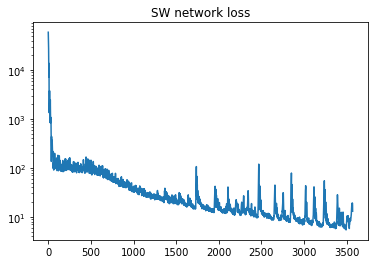

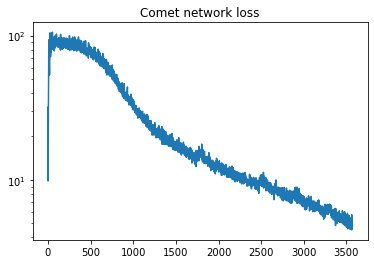

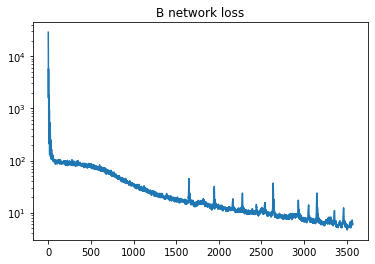

In [304]:

        
plt.plot(sw_training_loss)
plt.yscale("log")
plt.title("SW network loss")
plt.show()
plt.plot(comet_training_loss)
plt.yscale("log")
plt.title("Comet network loss")
plt.show()
plt.plot(B_training_loss)
plt.yscale("log")
plt.title("B network loss")
plt.show()

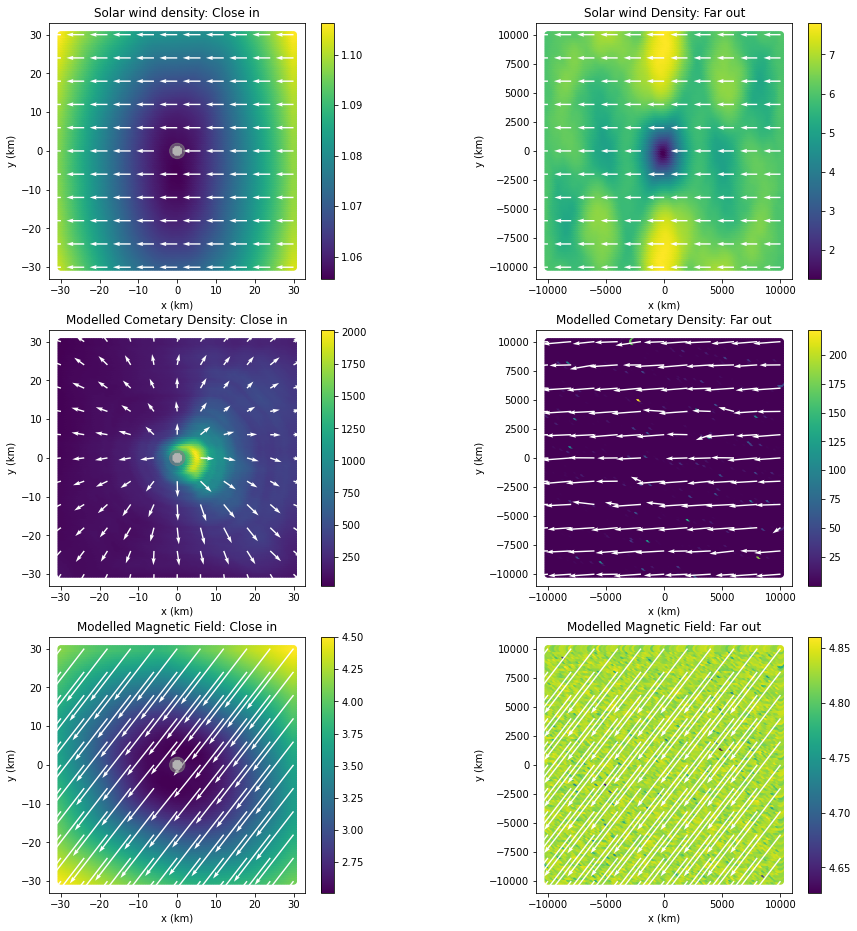

In [303]:
PLOT1()

In [234]:
def PLOT1():
    fig = plt.figure(figsize=(16,16))



    ax1 = fig.add_subplot(3,2,1)
    xyz = gen_grid(100,1)
    x,y,z = detach_xyz(xyz)
    nsw = nsw_scaling*torch.exp(sw_model(xyz)[:,0].reshape(-1,1)).detach().numpy()
    ax1.set_aspect('equal')
    scatter1 = ax1.scatter(x,y,c=nsw)

    xyz = gen_grid(11,1)
    x,y,z = detach_xyz(xyz)
    usw_x = sw_model(xyz)[:,3].reshape(-1,1)*100
    usw_y = sw_model(xyz)[:,4].reshape(-1,1)*100
    quiver1 = ax1.quiver(x,y,usw_x.detach().numpy(),usw_y.detach().numpy(),scale = 6000,color = "white")
    plt.colorbar(scatter1, ax=ax1,fraction=0.046, pad=0.04) 
    ax1.add_patch(plt.Circle((0, 0), rc*0.99, color='grey',alpha=0.6))
    ax1.set_xlabel('x (km)')
    ax1.set_ylabel('y (km)')
    plt.title("Solar wind density: Close in")


    ax2 = fig.add_subplot(3,2,3)
    xyz = gen_grid(100,1)
    x,y,z = detach_xyz(xyz)
    nc = nc_scaling*torch.exp(comet_model(xyz))[:,0].detach().numpy()
    ax2.set_aspect('equal')
    scatter2 = ax2.scatter(x,y,c=nc)

    xyz = gen_grid(11,1)
    x,y,z = detach_xyz(xyz)
    uc_x = comet_model(xyz)[:,3].detach().numpy()*100
    uc_y = comet_model(xyz)[:,4].detach().numpy()*100
    uc_z = comet_model(xyz)[:,5].detach().numpy()*100
    quiver2 = ax2.quiver(x,y,uc_x,uc_y,scale = 15,color = "white")
    plt.colorbar(scatter2, ax=ax2,fraction=0.046, pad=0.04)
    ax2.add_patch(plt.Circle((0, 0), rc*0.99, color='grey',alpha=0.6))
    ax2.set_xlabel('x (km)')
    ax2.set_ylabel('y (km)')
    plt.title("Modelled Cometary Density: Close in")


    ax3 = fig.add_subplot(3,2,5)
    xyz = gen_grid(100,1)
    x,y,z = detach_xyz(xyz)
    B_mag = ((B_model(xyz)[:,0].reshape(-1,1)**2+B_model(xyz)[:,1].reshape(-1,1)**2+B_model(xyz)[:,2].reshape(-1,1)**2)**0.5).detach().numpy()
    ax3.set_aspect('equal')
    scatter3 = ax3.scatter(x,y,c=B_mag)

    xyz = gen_grid(11,1)
    x,y,z = detach_xyz(xyz)
    B_x = B_model(xyz)[:,0].detach().numpy()
    B_y = B_model(xyz)[:,1].detach().numpy()
    quiver3 = ax3.quiver(x,y,B_x,B_y,scale = 15,color = "white")
    plt.colorbar(scatter3, ax=ax3,fraction=0.046, pad=0.04)
    ax3.add_patch(plt.Circle((0, 0), rc*0.99, color='grey',alpha=0.6))
    ax3.set_xlabel('x (km)')
    ax3.set_ylabel('y (km)')
    plt.title("Modelled Magnetic Field: Close in")



    ax4 = fig.add_subplot(3,2,2)
    xyz = gen_grid(100,1,-d1,d1,-d1,d1,-d1,d1)
    x,y,z = detach_xyz(xyz)
    nsw = nsw_scaling*torch.exp(sw_model(xyz)[:,0].reshape(-1,1)).detach().numpy()
    ax4.set_aspect('equal')
    scatter4 = ax4.scatter(x,y,c=nsw)

    xyz = gen_grid(11,1,-d1,d1,-d1,d1,-d1,d1)
    x,y,z = detach_xyz(xyz)
    usw_x = sw_model(xyz)[:,3].reshape(-1,1)*100
    usw_y = sw_model(xyz)[:,4].reshape(-1,1)*100
    quiver4 = ax4.quiver(x,y,usw_x.detach().numpy(),usw_y.detach().numpy(),scale = 6000,color = "white")
    plt.colorbar(scatter4, ax=ax4,fraction=0.046, pad=0.04)
    ax4.add_patch(plt.Circle((0, 0), rc*0.99, color='grey',alpha=0.6))
    ax4.set_xlabel('x (km)')
    ax4.set_ylabel('y (km)')
    plt.title("Solar wind Density: Far out")




    ax5 = fig.add_subplot(3,2,4)
    xyz = gen_grid(100,1,-d1,d1,-d1,d1,-d1,d1)
    x,y,z = detach_xyz(xyz)
    nc = nc_scaling*torch.exp(comet_model(xyz))[:,0].detach().numpy()
    ax5.set_aspect('equal')
    scatter5 = ax5.scatter(x,y,c=nc)

    xyz = gen_grid(11,1,-d1,d1,-d1,d1,-d1,d1)
    x,y,z = detach_xyz(xyz)
    uc_x = comet_model(xyz)[:,3].detach().numpy()*100
    uc_y = comet_model(xyz)[:,4].detach().numpy()*100
    uc_z = comet_model(xyz)[:,5].detach().numpy()*100
    quiver5 = ax5.quiver(x,y,uc_x,uc_y,scale = 15,color = "white")
    plt.colorbar(scatter5, ax=ax5,fraction=0.046, pad=0.04)
    ax5.add_patch(plt.Circle((0, 0), rc*0.99, color='grey',alpha=0.6))
    ax5.set_xlabel('x (km)')
    ax5.set_ylabel('y (km)')
    plt.title("Modelled Cometary Density: Far out")
    
    
    
    ax6 = fig.add_subplot(3,2,6)
    xyz = gen_grid(100,1,-d1,d1,-d1,d1,-d1,d1)
    x,y,z = detach_xyz(xyz)
    B_mag = ((B_model(xyz)[:,0].reshape(-1,1)**2+B_model(xyz)[:,1].reshape(-1,1)**2+B_model(xyz)[:,2].reshape(-1,1)**2)**0.5).detach().numpy()
    ax6.set_aspect('equal')
    scatter6 = ax6.scatter(x,y,c = B_mag)

    xyz = gen_grid(11,1,-d1,d1,-d1,d1,-d1,d1)
    x,y,z = detach_xyz(xyz)
    B_x = B_model(xyz)[:,0].detach().numpy()
    B_y = B_model(xyz)[:,1].detach().numpy()
    quiver5 = ax6.quiver(x,y,B_x,B_y,scale = 15,color = "white")
    plt.colorbar(scatter6, ax=ax6,fraction=0.046, pad=0.04)
    ax6.add_patch(plt.Circle((0, 0), rc*0.99, color='grey',alpha=0.6))
    ax6.set_xlabel('x (km)')
    ax6.set_ylabel('y (km)')
    plt.title("Modelled Magnetic Field: Far out")


In [ ]:
fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(2,2,1,projection='3d')
xyz = gen_grid(20,20)
nh = neutral_density(xyz).detach().numpy()
x,y,z = detach_xyz(xyz)
scatter1 = ax1.scatter(x,y,z,c=nh,alpha=0.2)
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_zlabel('z (m)')

In [ ]:
plt.plot(sw_training_loss)
plt.yscale("log")
plt.title("SW network loss")
plt.show()
plt.plot(comet_training_loss)
plt.yscale("log")
plt.title("Comet network loss")
plt.show()

In [ ]:
((nsw_scaling*100**3*torch.exp(bound[:,0]).reshape(-1,1) - nsw_upstream)**2).sum()

In [ ]:

                    (bound[:,3].reshape(-1,1) - usw_x_upstream)**2

In [162]:
5**3*100

12500